# Import All Dependencies

In [1]:
import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import cv2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer,DistilBertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from torchvision.utils import make_grid
from torchvision.models import resnet50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import itertools
import albumentations as A
import timm


c:\Users\richa\anaconda3\envs\fypYolo8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#List the parameter
debug = False
image_path = 'Flickr8/archive/Images'
captions_txt_path = "Flickr8/archive/captions.txt"
caption_csv_path = "Flickr8/archive/captions.csv."
batch_size = 32
num_workers = 0
head_lr = 1e-3
image_encoder_lr = 1e-4
text_encoder_lr = 1e-5
weight_decay = 1e-3
patience = 1
factor = 0.8
epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on :", device)

model_name = 'resnet50'
image_embedding = 2048
text_encoder_model = "distilbert-base-uncased"
text_embedding = 768
text_tokenizer = "distilbert-base-uncased"
max_length = 200

pretrained = True # for both image encoder and text encoder
trainable = True # for both image encoder and text encoder
temperature = 1.0

# image size
size = 224

# for projection head; used for both image and text encoders
num_projection_layers = 1
projection_dim = 256 
dropout = 0.1

Running on : cuda


# Load Dataset and Pre-process

In [3]:
#Read the caption file from dataset
df = pd.read_csv(captions_txt_path,sep=',')
print("Columns are: ", df.columns)
df

Columns are:  Index(['image', 'caption'], dtype='object')


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


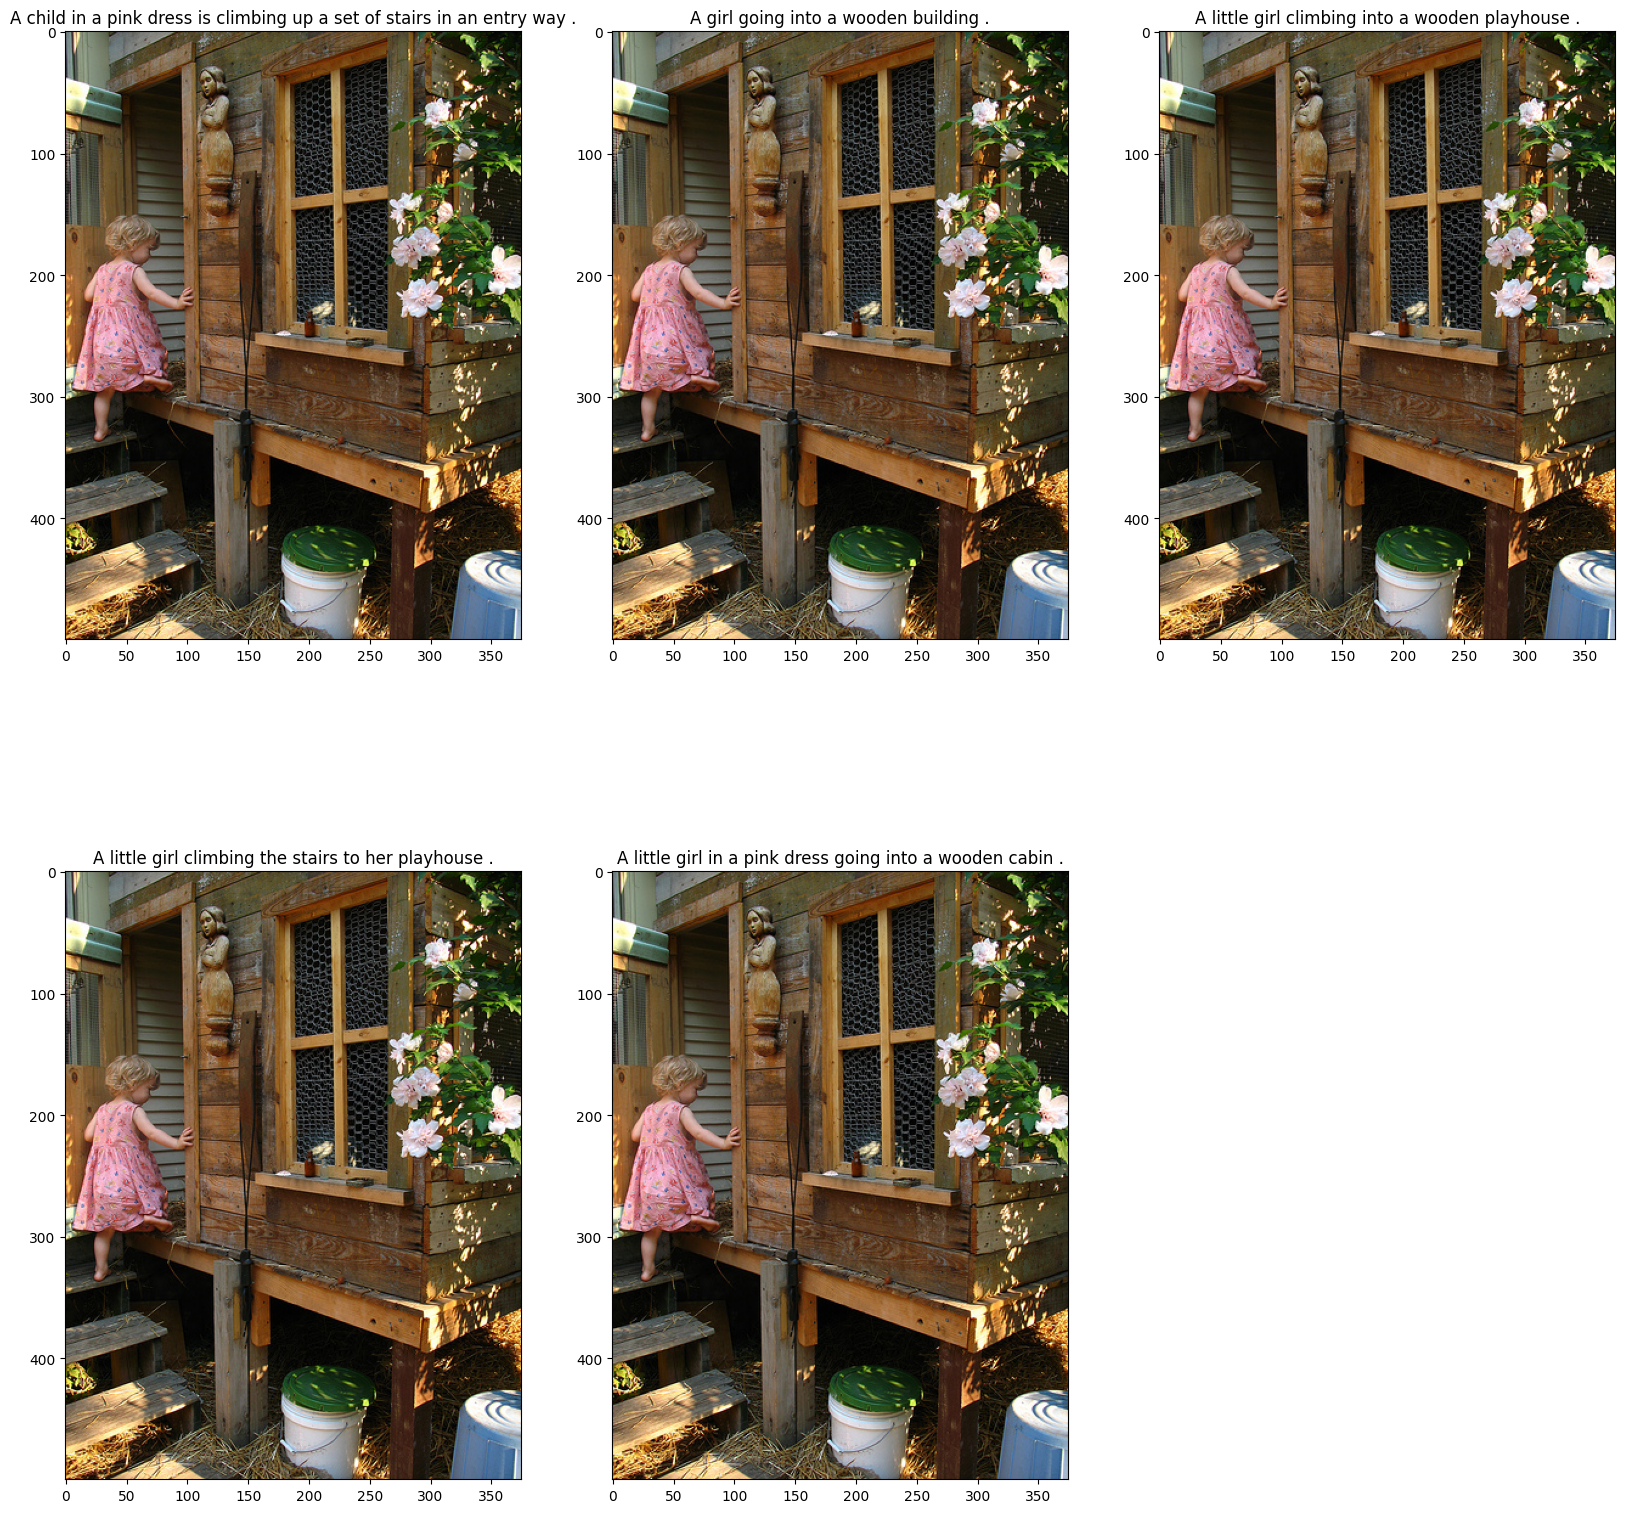

In [4]:
plt.figure(figsize=(20,20))
for i,filename in enumerate(df["image"][0:5]):
    plt.subplot(2,3,i+1)
    img=Image.open(os.path.join(image_path,filename))
    plt.imshow(img)
    plt.title(df['caption'][i])

We can see from the original file, 8000 images with 5 rows each. These 5 rows shows 5 different captions for 1 images. We want to prepocess the caption file so that we assign an ID for the same images. For example, those same 5 images have the same ID = 0

In [5]:
#Pre Process the caption file that it includes ID
filename_first = df['image'][0]
ids_col=[]
id=0
for filename in df["image"]:
    if filename == filename_first:
        ids_col.append(id)
    else: 
        filename_first= filename
        id+=1
        ids_col.append(id)

df['id'] = ids_col
df.to_csv(caption_csv_path, index=False)
df

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,8090
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,8090
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,8090
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,8090


# Create data loader

In [6]:
def make_train_valid_dfs(caption_csv_path):
    #read the modified caption file
    dataframe = pd.read_csv(caption_csv_path)

    #count how many image
    max_id = dataframe["id"].max() + 1 if not debug else 100
    image_ids = np.arange(0, max_id)

    #select 20% of the train set for validation
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [7]:
class ImageTextDataset(Dataset):
    def __init__(self, img_filename,img_caption , tokenizer):

        self.img_filename = img_filename
        self.img_caption= list(img_caption)
        self.encoded_captions = tokenizer( list(img_caption), padding = True, max_length = max_length)
        self.transform = A.Compose([
                A.Resize(size, size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
                ])

    def __len__(self):
        return len(self.img_caption)

    def __getitem__(self, index):
        item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(os.path.join(image_path,self.img_filename[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image']
        item['image'] = torch.tensor(image).permute(2,0,1).float()
        item['caption'] = self.img_caption[index]


        return item

In [9]:
# tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
# train_df, valid_df = make_train_valid_dfs(caption_csv_path=caption_csv_path)

# train_set=ImageTextDataset(train_df,image_path,tokenizer)
# valid_set=ImageTextDataset(valid_df,image_path,tokenizer)

# train_dataloader=DataLoader(train_set, batch_size=32, shuffle=True)
# valid_dataloader=DataLoader(valid_set, batch_size=32, shuffle=False)

# print("length of trainloader is :",len(train_dataloader))
# print("length of validloader is :",len(valid_dataloader))

tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
train_df, valid_df = make_train_valid_dfs(caption_csv_path=caption_csv_path)

train_set=ImageTextDataset(train_df['image'].values,train_df['caption'].values,tokenizer)
valid_set=ImageTextDataset(valid_df['image'].values,valid_df['caption'].values,tokenizer)

train_dataloader=DataLoader(train_set, batch_size=32, shuffle=True)
valid_dataloader=DataLoader(valid_set, batch_size=32, shuffle=False)

print("length of trainloader is :",len(train_dataloader))
print("length of validloader is :",len(valid_dataloader))

c:\Users\richa\anaconda3\envs\fypYolo8\lib\site-packages\transformers\tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


length of trainloader is : 1012
length of validloader is : 253


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'A little boy sitting on a green swing .')

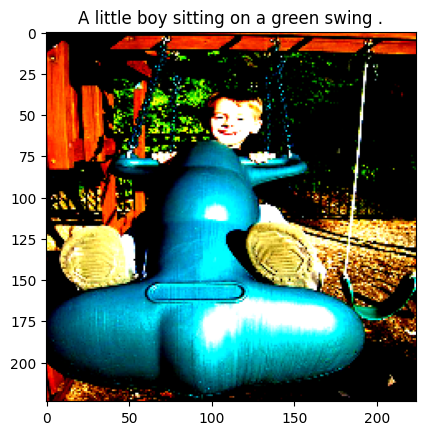

In [10]:
image=next(iter(train_dataloader))
plt.imshow(image['image'][0].permute(1,2,0))
plt.title(image['caption'][0])

# Construct the CLIP Model

In [29]:
class ImageEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    #use resnet50 from torch models
    self.pretrain_model=resnet50(pretrained=True)
    modules=list(self.pretrain_model.children())[:-1]
    self.model=nn.Sequential(*modules)

    for p in self.model.parameters():
      p.requires_grad=True # record the gradient info

  def forward(self, x):
    out=self.model(x)
    output=out.flatten(1)
    return output

class TextEncoder(nn.Module):
  def __init__(self, text_encoder_model = text_encoder_model):
    super().__init__()
    self.pretrain_model=DistilBertModel.from_pretrained(text_encoder_model)

    for p in self.pretrain_model.parameters():
      p.requires_grad = True

  def forward(self, input_ids,attention_mask):
    output = self.pretrain_model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = output.last_hidden_state

    return last_hidden_state[:, 0, :]
  
class Projection(nn.Module):
    def __init__(self, embedding_dim, projection_dim=projection_dim, dropout=dropout):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU() # activation function
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

def cross_entropy(prediction, targets, reduction='none'):
  log_softmax=nn.LogSoftmax(dim=-1)
  loss=(-targets*log_softmax(prediction)).sum(1)
  if reduction=='none':
    return loss
  elif reduction == 'mean':
    return loss.mean()
  
class CLIP(torch.nn.Module):

    def __init__(self, 
                 temperature=temperature, 
                 image_embedding= image_embedding,
                 text_embedding= text_embedding
                 ):
        super(CLIP, self).__init__()
        self.projection_dim = projection_dim
        self.text_encoder= TextEncoder()
        self.image_encoder = ImageEncoder()
        self.image_projector = Projection(embedding_dim=image_embedding)
        self.text_projector = Projection(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        
        # Text -> text_embedding -> text_projection
        text_embedding= self.text_encoder(input_ids=batch['input_ids'],
                                          attention_mask=batch["attention_mask"])
        text_projection = self.text_projector(text_embedding)

        # Image -> image_embedding -> image_projection
        image_embedding=self.image_encoder(batch['image'])
        image_projection = self.image_projector(image_embedding)

        # loss
        logits = (text_projection @ image_projection.T) / self.temperature
        images_similarity = image_projection @ image_projection.T
        texts_similarity = text_projection @ text_projection.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    

# Training Loop and Evaluation

In [30]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def train_epoch(model, train_dataloader, optimizer, device, train_loss_graph):
  model = model.to(device)

  total_loss = 0.0
  counter=0
  
  train_bar=tqdm(train_dataloader, desc='Train')
  for batch in train_bar:
    batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
    loss = model(batch)

    # - - - -  Backpropagation  - - - -
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count = len(batch["image"])
    total_loss += loss.item() *count
    counter+=count
    avg_loss=total_loss/counter
    
    train_bar.set_postfix(loss=avg_loss, lr=get_lr(optimizer))
    train_loss_graph.append(avg_loss)

  avg_trainloss = total_loss / counter
  return avg_trainloss, train_loss_graph


def eval_epoch(model, valid_dataloader, device, val_loss_graph):
  model = model.to(device)

  total_loss=0.0
  counter=0

  eval_bar=tqdm(valid_dataloader, desc='Eval')
  for batch in eval_bar:
    batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
    loss = model(batch)

    count = len(batch["image"])
    total_loss += loss.item() *count
    counter+=count

    avg_loss=total_loss/counter
    eval_bar.set_postfix(loss=avg_loss)

    val_loss_graph.append(avg_loss)

  avg_valloss = total_loss / counter

  return avg_valloss,val_loss_graph

In [31]:
model=CLIP().to(device)

params = [
    {"params": model.image_encoder.parameters(), "lr": image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": text_encoder_lr},
    {"params": itertools.chain(
        model.image_projector.parameters(), model.text_projector.parameters()
    ), "lr": head_lr, "weight_decay": weight_decay}
]
optimizer = torch.optim.AdamW(params=params, weight_decay=0.)
#learning rate scheduler.
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_steps)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=patience, factor=factor
)

c:\Users\richa\anaconda3\envs\fypYolo8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\richa\anaconda3\envs\fypYolo8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
# - - - - - - - - -  Training & validation loop  - - - - - - - - -
best_loss = float('inf')
train_loss_graph=[]
val_loss_graph=[]

for epoch in (range(epochs)):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)

  model.train()
  avg_trainloss,train_loss_graph = train_epoch(model, train_dataloader, optimizer, device,train_loss_graph)

  print(f'Train loss : {avg_trainloss}')

  model.eval()
  with torch.no_grad():
    avg_valloss,val_loss_graph = eval_epoch(model, valid_dataloader, device,val_loss_graph)

  print(f'Val loss : {avg_valloss}')

  if avg_valloss < best_loss:
    best_loss = avg_valloss
    torch.save(model.state_dict(), f"Models/clip_epoch{epoch+1}_val{avg_valloss:.2f}.pt")

  scheduler.step(avg_valloss)

Epoch 1/1
----------


Train: 100%|██████████| 1012/1012 [03:55<00:00,  4.31it/s, loss=2.41, lr=0.0001]


Train loss : 2.4060821182665566


Eval: 100%|██████████| 253/253 [00:38<00:00,  6.64it/s, loss=2.18]


Val loss : 2.181531737672973


# Testing

In [33]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
    valid_set=ImageTextDataset(valid_df['image'].values,valid_df['caption'].values,tokenizer)
    valid_dataloader=DataLoader(valid_set, batch_size=32, shuffle=False)
    
    model = CLIP().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            image_features = model.image_encoder(batch["image"].to(device))
            image_embeddings = model.image_projector(image_features)

            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [34]:
_, valid_df = make_train_valid_dfs(caption_csv_path=caption_csv_path)
model, image_embeddings = get_image_embeddings(valid_df, "Models/clip_epoch1_val2.18.pt")

100%|██████████| 253/253 [00:31<00:00,  8.09it/s]


In [35]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projector(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    print(dot_similarity)
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    print(matches)
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

def find_matches_github(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features) #<------------- THE ONLY DIFFERENT LINE
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    print(dot_similarity)
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    print(matches)
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

tensor([[0.1041, 0.1041, 0.1041,  ..., 0.1063, 0.1063, 0.1063]],
       device='cuda:0')
['874665322_9ad05c4065.jpg', '50030244_02cd4de372.jpg', '689776124_07f560a920.jpg', '2053441349_a98b5fc742.jpg', '1361420539_e9599c60ae.jpg', '380041023_0dfd712ef1.jpg', '2558312618_13d362df66.jpg', '3623302162_099f983d58.jpg', '2665904080_8a3b9639d5.jpg']


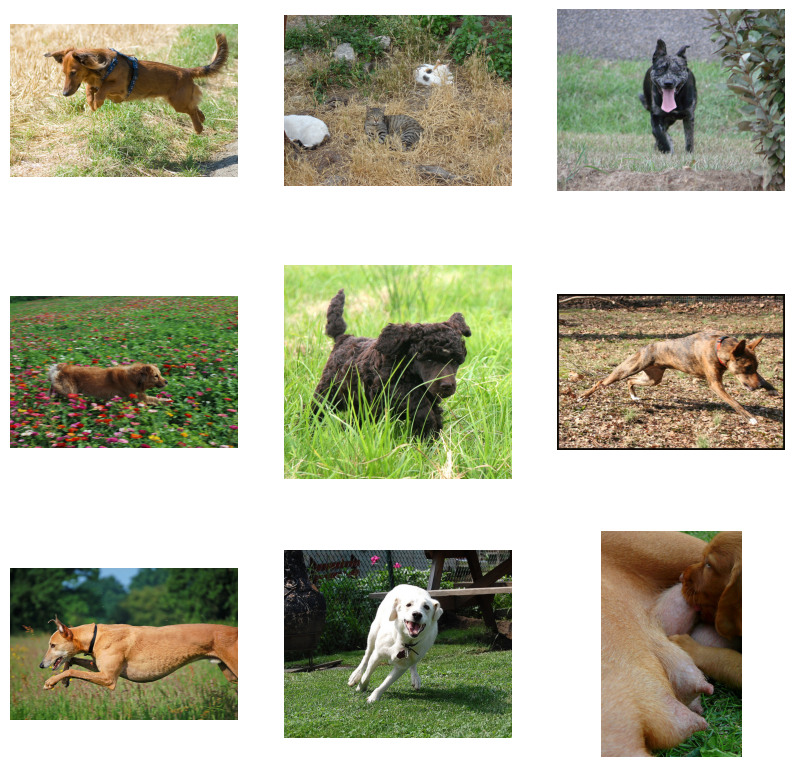

In [39]:
find_matches(model, 
             image_embeddings,
             query="a dog on grass",
             image_filenames=valid_df['image'].values,
             n=9)